## Data Preparation and Preprocessing

In [50]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, brier_score_loss
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
# Load the dataset
data = pd.read_csv("heart_data.csv")
data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [54]:
summary_table = pd.DataFrame({
    'Column': data.columns,
    'Rows': [data[col].count() for col in data.columns],
    '% Missing Rows': [data[col].isnull().mean() * 100 for col in data.columns],
    'Data Type': data.dtypes.values,
    'First Row': data.iloc[0].values,
    'Unique Values': [data[col].nunique() for col in data.columns]
})

print(summary_table)

      Column  Rows  % Missing Rows Data Type  First Row  Unique Values
0        age   303        0.000000     int64       63.0             41
1        sex   303        0.000000     int64        1.0              2
2         cp   303        0.000000     int64        1.0              4
3   trestbps   303        0.000000     int64      145.0             50
4       chol   303        0.000000     int64      233.0            152
5        fbs   303        0.000000     int64        1.0              2
6    restecg   303        0.000000     int64        2.0              3
7    thalach   303        0.000000     int64      150.0             91
8      exang   303        0.000000     int64        0.0              2
9    oldpeak   303        0.000000   float64        2.3             40
10     slope   303        0.000000     int64        3.0              3
11        ca   299        1.320132   float64        0.0              4
12      thal   301        0.660066   float64        6.0              3
13    

### Summary of the Dataset

1. **General Overview**:
   - The dataset contains 303 rows for most columns, with two columns having missing values:
     - `ca` (number of major vessels): 1.32% missing values (4 missing rows).
     - `thal` (thalassemia): 0.66% missing values (2 missing rows).
   - Columns data types are predominantly `int64`, with a few `float64` types.

2. **Insights**:
   - The dataset is mostly complete with minimal missing values in the `ca` and `thal` columns, which might require imputation or handling.
   - High cardinality in `chol`, `thalach`, and `trestbps` suggests these are continuous variables with significant variability.
   - Binary columns (`sex`, `fbs`, `exang`) and categorical columns (`cp`, `restecg`, `slope`, `thal`, `num`) provide discrete classifications for analysis.
   - `num` serves as the target variable, with 5 unique classes indicating varying degrees of heart disease severity.

## Data Preprocessing

In [55]:
# Fill missing values with the mean of the respective column
data.fillna(data.mean(), inplace=True)

In [56]:
# Normalize the numerical features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [59]:
# Transform the target variable 'num' for binary classification
data_scaled['num'] = data_scaled['num'].apply(lambda x: 1 if x > 0 else 0)

# Split the data into features (X) and target (y)
X = data_scaled.drop(columns=['num'])
y = data_scaled['num']

## EDA

#### Correlation Heatmap

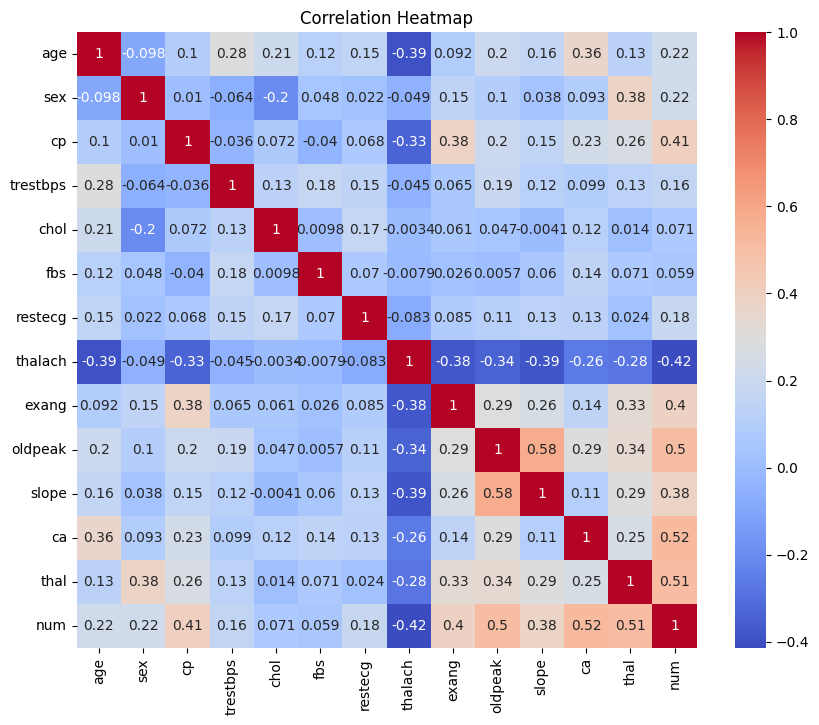

In [57]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

### Summary of the Correlation Heatmap

1. **Strong Positive Correlations**:
   - `num` (Heart disease diagnosis) is strongly correlated with:
     - `ca` (number of major vessels) at 0.52.
     - `thal` (thalassemia) at 0.51.
     - `oldpeak` (ST depression) at 0.50.
     - `cp` at 0.41.
     - `exang` (exercise-induced angina) at 0.40.

2. **Strong Negative Correlations**:
   - `thalach` (maximum heart rate achieved) is negatively correlated with:
     - `num` at -0.42.
     - `age` & `slope` at -0.39.
     - `exang` at -0.38.
     - `oldpeak` at -0.34.
     - `cp` at -0.33.

3. **Age Relationships**:
   - Negatively correlated with `thalach` (-0.39).
   - Positively correlated with `trestbps` (resting blood pressure) at 0.28.

4. **Chest Pain Type (cp)**:
   - Positively correlated with `slope` (0.38).
   - Negatively correlated with `exang` (-0.33).

### Insights:
- The presence of heart disease (`num`) shows strong relationships with several key clinical features such as `ca`, `thal`, and `oldpeak`, suggesting these are critical indicators for predicting heart conditions.
- Maximum heart rate (`thalach`) is inversely related to age and heart disease presence, indicating it may decrease with age and worsening heart health.
- ST depression (`oldpeak`) has a significant relationship with exercise-induced angina and the slope of the peak exercise ST segment.

### Univariate Analysis

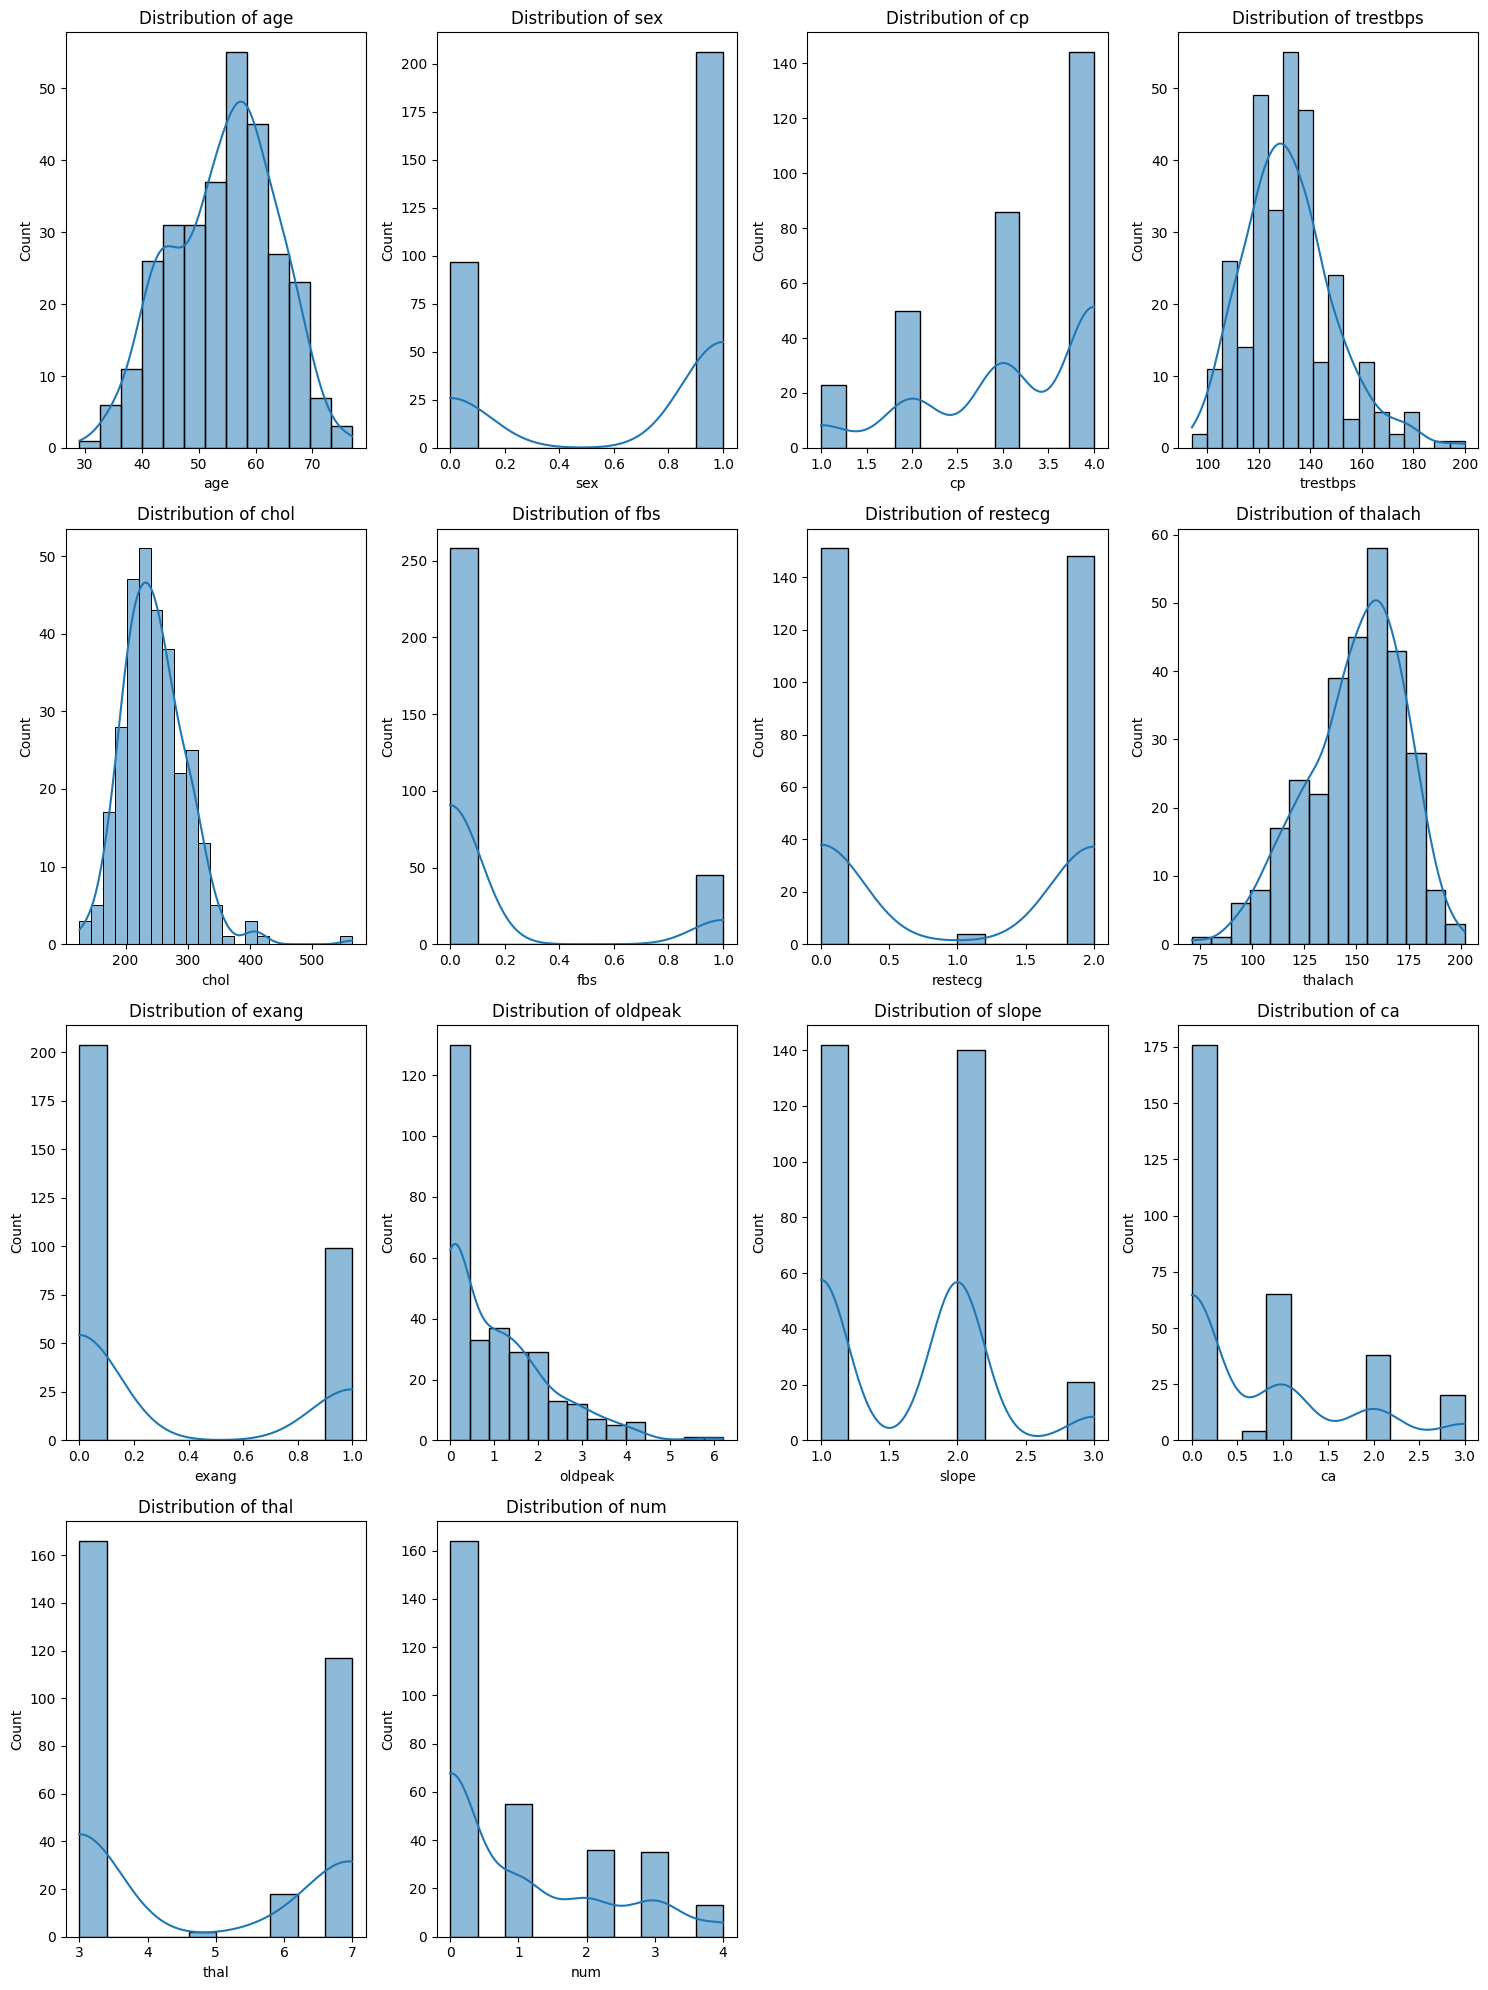

In [58]:
num_cols = len(data.columns)
num_rows = (num_cols + 2) // 4

plt.figure(figsize=(15, 5 * num_rows))

for i, col in enumerate(data.columns):
    plt.subplot(num_rows, 4, i + 1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

#### Summary of the Charts

1. **Age Distribution**:
   - The ages are distributed normally, with a peak around the 50-60 age group.

2. **Sex Distribution**:
   - The dataset is heavily skewed towards males (1), with very few females (0).

3. **Chest Pain Type (cp)**:
   - Most individuals experience types 1 and 4 of chest pain, with fewer cases in types 2 and 3.

4. **Resting Blood Pressure (trestbps)**:
   - Blood pressure is concentrated around 120-140, with a normal-like distribution.

5. **Cholesterol (chol)**:
   - Cholesterol levels are distributed with a peak around 200-300, slightly skewed to the right.

6. **Fasting Blood Sugar (fbs)**:
   - Most individuals have fasting blood sugar below the threshold (0), with few above (1).

7. **Resting ECG Results (restecg)**:
   - The majority of individuals fall into categories 0 and 2, with few in category 1.

8. **Maximum Heart Rate Achieved (thalach)**:
   - Heart rate peaks around 140-160, with a bell-shaped distribution.

9. **Exercise-Induced Angina (exang)**:
   - Most individuals do not have exercise-induced angina (0), with fewer having it (1).

10. **ST Depression (oldpeak)**:
    - The values are right-skewed, with most below 2 and a long tail towards higher values.

11. **Slope of the Peak (slope)**:
    - Categories 1 and 2 dominate, with fewer individuals in category 3.

12. **Number of Major Vessels (ca)**:
    - Most individuals have 0 or 1 vessel, with very few having 2 or 3.

13. **Thalassemia (thal)**:
    - The distribution is concentrated around categories 3, 6, and 7.

14. **Diagnosis of Heart Disease (num)**:
    - Class 0 dominates, but there is a noticeable distribution across classes 1 to 4, indicating varying degrees of heart disease presence.

## Implementing the Algorithms:

In [69]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the datasets
print("\nShapes of the datasets:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Shapes of the datasets:
X_train: (242, 13), X_test: (61, 13)
y_train: (242,), y_test: (61,)


### 1. Random Forest Implementation

In [61]:
# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Random Forest - Confusion Matrix:
[[26  3]
 [ 4 28]]


### 2. Deep Learning (LSTM) Implemenation

In [62]:
# Reshape input data for LSTM (3D shape required)
X_train_dl = np.expand_dims(X_train, axis=2)
X_test_dl = np.expand_dims(X_test, axis=2)

# Convert target to categorical format
y_train_dl = to_categorical(y_train)
y_test_dl = to_categorical(y_test)

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: 0 and 1
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("\nTraining LSTM Model...")
history = lstm_model.fit(X_train_dl, y_train_dl, validation_data=(X_test_dl, y_test_dl), epochs=20, batch_size=32)

# Evaluate the model
print("\nEvaluating LSTM Model...")
loss, accuracy = lstm_model.evaluate(X_test_dl, y_test_dl)
print(f"LSTM Model Accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
y_pred_dl = lstm_model.predict(X_test_dl)
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)

print("\nLSTM - Classification Report:")
print(classification_report(y_test, y_pred_dl_classes))

print("LSTM - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dl_classes))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM Model...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5365 - loss: 0.6903 - val_accuracy: 0.7541 - val_loss: 0.6731
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7162 - loss: 0.6718 - val_accuracy: 0.7541 - val_loss: 0.6526
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7909 - loss: 0.6519 - val_accuracy: 0.8197 - val_loss: 0.6171
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8056 - loss: 0.6228 - val_accuracy: 0.7869 - val_loss: 0.5765
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8338 - loss: 0.5760 - val_accuracy: 0.8033 - val_loss: 0.5146
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7295 - loss: 0.5383 - val_accuracy: 0.6393 - val_loss: 0.5554
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7642 - loss: 0.4945 - val_accuracy: 0.7213 - val_loss: 0.5208
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8079 - loss: 0.4484 - val_accuracy: 0.

### 3. Additional Algorithm (Support Vector Machine - SVM) implementation

In [63]:
# Train a Support Vector Machine (SVM) model
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Evaluate the model
print("\nSVM - Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("SVM - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


SVM - Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        29
           1       0.91      0.91      0.91        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

SVM - Confusion Matrix:
[[26  3]
 [ 3 29]]


## Performance Metrics Calculation

### Functions for Metric Calculation

In [64]:
# Function to calculate confusion matrix and derived metrics
def calculate_metrics(y_true, y_pred, y_pred_prob=None):
    """
    Calculate and return a dictionary of performance metrics.
    """
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Manual Metrics
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

    metrics = {
        "True Positives (TP)": tp,
        "True Negatives (TN)": tn,
        "False Positives (FP)": fp,
        "False Negatives (FN)": fn,
        "False Positive Rate (FPR)": fpr,
        "False Negative Rate (FNR)": fnr
    }

    # Advanced Metrics
    if y_pred_prob is not None:
        metrics["ROC AUC"] = roc_auc_score(y_true, y_pred_prob)
        metrics["Brier Score"] = brier_score_loss(y_true, y_pred_prob)

    return metrics

# Function to calculate ROC curve
def plot_roc_curve(y_true, y_pred_prob, model_name):
    """
    Plot ROC curve for a given model's predictions.
    """
    import matplotlib.pyplot as plt

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_pred_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()


### 1. Random Forest


Random Forest - Metrics:
True Positives (TP): 28
True Negatives (TN): 26
False Positives (FP): 3
False Negatives (FN): 4
False Positive Rate (FPR): 0.10344827586206896
False Negative Rate (FNR): 0.125
ROC AUC: 0.9364224137931034
Brier Score: 0.10273022883405823


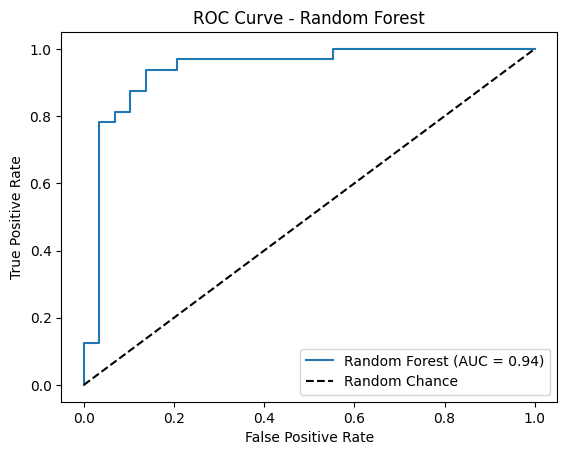

In [65]:
# Get predictions and probabilities
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_metrics = calculate_metrics(y_test, y_pred_rf, y_pred_rf_prob)
print("\nRandom Forest - Metrics:")
for key, value in rf_metrics.items():
    print(f"{key}: {value}")

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_rf_prob, "Random Forest")


### LSTM


LSTM - Metrics:
True Positives (TP): 22
True Negatives (TN): 24
False Positives (FP): 5
False Negatives (FN): 10
False Positive Rate (FPR): 0.1724137931034483
False Negative Rate (FNR): 0.3125
ROC AUC: 0.9019396551724138
Brier Score: 0.1351142117663488


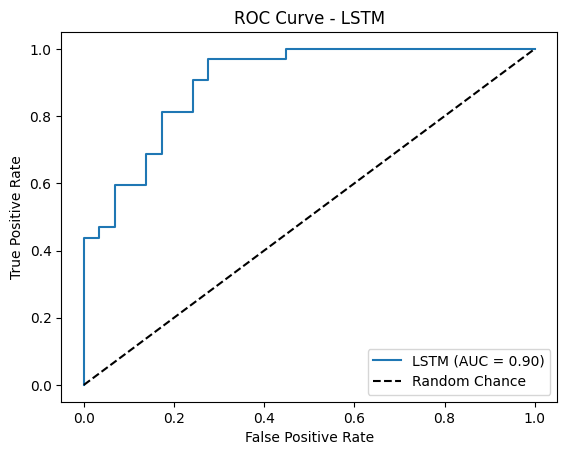

In [66]:
# Get predictions and probabilities
y_pred_dl_classes = np.argmax(y_pred_dl, axis=1)  # Predicted classes
y_pred_dl_prob = y_pred_dl[:, 1]  # Probability of class 1

# Calculate metrics
lstm_metrics = calculate_metrics(y_test, y_pred_dl_classes, y_pred_dl_prob)
print("\nLSTM - Metrics:")
for key, value in lstm_metrics.items():
    print(f"{key}: {value}")

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_dl_prob, "LSTM")


### SVM


SVM - Metrics:
True Positives (TP): 29
True Negatives (TN): 26
False Positives (FP): 3
False Negatives (FN): 3
False Positive Rate (FPR): 0.10344827586206896
False Negative Rate (FNR): 0.09375
ROC AUC: 0.9504310344827586
Brier Score: 0.09103098817702202


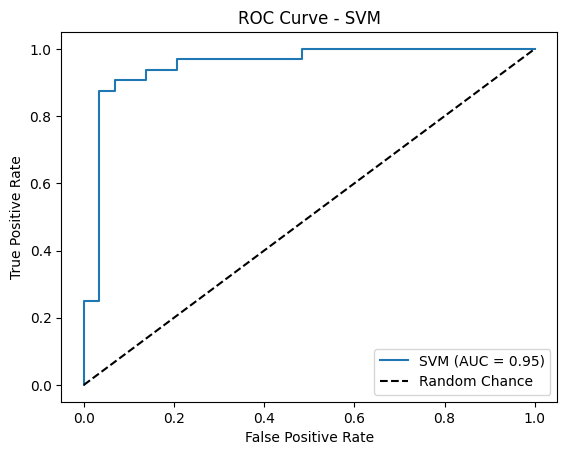

In [67]:
# Get predictions and probabilities
y_pred_svm = svm.predict(X_test)
y_pred_svm_prob = svm.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate metrics
svm_metrics = calculate_metrics(y_test, y_pred_svm, y_pred_svm_prob)
print("\nSVM - Metrics:")
for key, value in svm_metrics.items():
    print(f"{key}: {value}")

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_svm_prob, "SVM")


## Results Presentation and Discussion

### **1. Tabular Results**

| Algorithm         | TP  | TN  | FP  | FN  | FPR   | FNR   | ROC AUC | Brier Score |
|-------------------|------|------|------|------|--------|--------|---------|-------------|
| Random Forest     | 28   | 26   | 3    | 4    | 0.1034 | 0.1250 | 0.9364  | 0.1027      |
| LSTM              | 22   | 24   | 5    | 10   | 0.1724 | 0.3125 | 0.9019  | 0.1351      |
| SVM               | 29   | 26   | 3    | 3    | 0.1034 | 0.0938 | 0.9504  | 0.0910      |

---

### **2. Discussion**

### **Random Forest**
- **Performance:**
  - Achieved an accuracy of 89% with a **ROC AUC of 0.9364**.
  - False Positive Rate (FPR): **10.34%**, and False Negative Rate (FNR): **12.5%**.
- **Strengths:**
  - Performed well in terms of precision and recall, balancing the trade-off between false positives and false negatives.
  - Achieved a low Brier Score of **0.1027**, indicating good probability calibration.
- **Weaknesses:**
  - Slightly higher FNR compared to SVM, which may affect the detection of positive cases.

---

#### **LSTM**
- **Performance:**
  - Achieved an accuracy of 75.41% with a **ROC AUC of 0.9019**.
  - FPR: **17.24%**, FNR: **31.25%**.
- **Strengths:**
  - Captures sequential dependencies in data, which can be beneficial for time-series datasets.
  - Moderate ROC AUC value indicates reasonable discrimination ability.
- **Weaknesses:**
  - Relatively higher FNR and FPR compared to Random Forest and SVM.
  - Longer training time and more computationally intensive.

---

#### **SVM**
- **Performance:**
  - Achieved the highest accuracy of 90% with a **ROC AUC of 0.9504**.
  - FPR: **10.34%**, FNR: **9.38%**.
- **Strengths:**
  - Best performance among the three algorithms in terms of ROC AUC and Brier Score (**0.0910**).
  - Balanced precision and recall, demonstrating robustness in classification.
- **Weaknesses:**
  - While computationally efficient for this dataset, SVM may not scale well for larger datasets.

---

### **3. Model Comparison**

| Metric            | Best Algorithm   | Reason                                  |
|--------------------|------------------|-----------------------------------------|
| Accuracy           | SVM              | Highest accuracy of 90%.               |
| ROC AUC            | SVM              | Best ROC AUC of 0.9504.                |
| FPR                | Random Forest/SVM| Lowest FPR of 10.34%.                  |
| FNR                | SVM              | Lowest FNR of 9.38%.                   |
| Brier Score        | SVM              | Lowest Brier Score of 0.0910.          |

#### **Key Insights**
- **SVM** emerged as the best-performing algorithm due to its high accuracy, low FPR/FNR, and superior probability calibration (lowest Brier Score).
- **Random Forest** provided competitive results and would be a suitable choice for cases requiring interpretability of feature importance.
- **LSTM**, while promising for sequential data, underperformed in this scenario, possibly due to the limited dataset size and lack of time-series features.

---

### **4. Justification for Best Algorithm**
The **Support Vector Machine (SVM)** demonstrated superior performance across multiple metrics, making it the best choice for this dataset:
- **High Accuracy and ROC AUC**: Indicates reliable classification of both positive and negative cases.
- **Low FPR and FNR**: Minimizes the cost of false positives and false negatives.
- **Efficient for Small Datasets**: SVM works well with smaller datasets, as seen in this case.

For practical applications, SVM provides robust and consistent results, making it the recommended model for detecting heart disease based on this dataset.
